In [ ]:
%%capture
! python3 -m pip install transformers datasets evaluate scikit-learn tqdm

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification,\
    TrainingArguments, Trainer, pipeline, DataCollatorWithPadding, set_seed
import evaluate
import numpy as np
import torch.nn as nn
import math
import time
from tqdm import tqdm
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
set_seed(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
ds = load_dataset("hate_speech_offensive")
# print(ds)
ds = ds["train"]
ds = ds.train_test_split(test_size=0.1)
cls_freq = np.unique(ds["train"][:]['class'],return_counts=True)[1]
print(ds)
print(cls_freq)

Generating train split:   0%|          | 0/24783 [00:00<?, ? examples/s]

Dataset hate_speech_offensive downloaded and prepared to /root/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 22304
    })
    test: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 2479
    })
})
[ 1291 17296  3717]


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples["tweet"], truncation=True)
    tokenized_inputs['labels'] = examples["class"]
    return tokenized_inputs
tokenized_ds = ds.map(preprocess_function, batched=True)
tokenized_ds = tokenized_ds.remove_columns("tweet")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
recall = evaluate.load("recall")
precision = evaluate.load("precision")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    predictions[predictions>0] = 1
    predictions = 1 - predictions
    labels_hate = copy.deepcopy(labels)
    labels[labels>0] = 1
    labels = 1 - labels
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1s = f1.compute(predictions=predictions, references=labels)
    rec = recall.compute(predictions=predictions, references=labels)
    pre = precision.compute(predictions=predictions, references=labels)
    return f1s

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
            "roberta-base", num_labels=3)
class CustomTrainer(Trainer):
    def __init__(self, weighted_training=False, **kwargs,):
          super().__init__(**kwargs)
          self.weighted_training = weighted_training
    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()

        if self.weighted_training:
            wts = sum(cls_freq)/torch.tensor(cls_freq)
            print("wts",wts)
        else:
            wts = torch.ones(3)
        criterion = torch.nn.CrossEntropyLoss(weight = wts).to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            train_pcacc_per_epoch = [0 for cls in range(3)]
            train_pccount_per_epoch = [0 for cls in range(3)]
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(inputs['input_ids'],attention_mask = inputs['attention_mask'])
                    # get the loss
                    loss = criterion(output['logits'], labels)
                    train_loss_per_epoch += loss.item()
                    #calculate gradients
                    loss.backward()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
                    for cls in range(3):
                        train_pcacc_per_epoch[cls] += (output['logits'].argmax(1)[labels==cls] == cls).sum().item()
                        train_pccount_per_epoch[cls] += sum(labels==cls)
                    
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            train_pcacc_per_epoch = [(train_pcacc_per_epoch[cls]/train_pccount_per_epoch[cls]).item() for cls in range(3)]
            
            
            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            eval_pcacc_per_epoch = [0 for cls in range(3)]
            eval_pccount_per_epoch = [0 for cls in range(3)]
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for step, inputs in enumerate(eval_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    with torch.no_grad():
                        output = model(inputs['input_ids'],attention_mask = inputs['attention_mask'])
                        loss = criterion(output['logits'], labels)
                        eval_loss_per_epoch += loss.item()
                        eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
                        for cls in range(3):
                            eval_pcacc_per_epoch[cls] += (output['logits'].argmax(1)[labels==cls] == cls).sum().item()
                            eval_pccount_per_epoch[cls] += sum(labels==cls)
            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
            eval_pcacc_per_epoch = [(eval_pcacc_per_epoch[cls]/eval_pccount_per_epoch[cls]).item() for cls in range(3)]
        
            
            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}% | Train Per Class Acc: {train_pcacc_per_epoch}')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}% | Eval Per Class Acc: {eval_pcacc_per_epoch}')
            train_loss.append(train_loss_per_epoch)
            eval_loss.append(eval_loss_per_epoch)
            train_acc.append(train_acc_per_epoch)
            eval_acc.append(eval_acc_per_epoch)
            train_pcacc.append(train_pcacc_per_epoch)
            eval_pcacc.append(eval_pcacc_per_epoch)
    
        print(f'Time: {(time.time()-start)/60:.3f} minutes')

In [ ]:
##Use standard CE loss
device=torch.device("cuda") if torch.cuda.is_available() else "cpu"
print(device)
train_loss=[]
eval_loss=[]
train_acc=[]
eval_acc=[]
train_pcacc=[]
eval_pcacc=[]
# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#trainingarguments
training_args = TrainingArguments(
    output_dir="ce_model",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # remove_unused_columns=False,
)

# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#id1
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
# import warnings
# warnings.filterwarnings("ignore")
trainer.train()

cuda


Evaluation Epoch 0: 100%|██████████| 155/155 [00:09<00:00, 17.06batch/s]


	Train Loss: 0.019 | Train Acc: 99.39% | Train Per Class Acc: [0.9566227793693542, 0.9967622756958008, 0.9938122630119324]
	Eval Loss: 0.529 | Eval Acc: 91.53% | Eval Per Class Acc: [0.23741008341312408, 0.9662091135978699, 0.9125561118125916]


Evaluation Epoch 1: 100%|██████████| 155/155 [00:10<00:00, 15.15batch/s]


	Train Loss: 0.010 | Train Acc: 99.68% | Train Per Class Acc: [0.9829589128494263, 0.9980920553207397, 0.9956954717636108]
	Eval Loss: 0.542 | Eval Acc: 91.33% | Eval Per Class Acc: [0.23021583259105682, 0.9699050188064575, 0.8878924250602722]


Evaluation Epoch 2: 100%|██████████| 155/155 [00:09<00:00, 17.07batch/s]


	Train Loss: 0.010 | Train Acc: 99.70% | Train Per Class Acc: [0.9806351661682129, 0.9981498718261719, 0.997309684753418]
	Eval Loss: 0.570 | Eval Acc: 91.41% | Eval Per Class Acc: [0.3381294906139374, 0.9556494355201721, 0.9192825555801392]


Evaluation Epoch 3: 100%|██████████| 155/155 [00:09<00:00, 17.10batch/s]


	Train Loss: 0.008 | Train Acc: 99.72% | Train Per Class Acc: [0.9829589128494263, 0.9983811378479004, 0.9965025782585144]
	Eval Loss: 0.522 | Eval Acc: 90.77% | Eval Per Class Acc: [0.3381294906139374, 0.9508976340293884, 0.9035874605178833]


Evaluation Epoch 4: 100%|██████████| 155/155 [00:09<00:00, 17.05batch/s]

	Train Loss: 0.004 | Train Acc: 99.89% | Train Per Class Acc: [0.9945778250694275, 0.9994796514511108, 0.9975787401199341]
	Eval Loss: 0.626 | Eval Acc: 90.89% | Eval Per Class Acc: [0.3669064939022064, 0.9503695964813232, 0.9035874605178833]
Time: 24.906 minutes


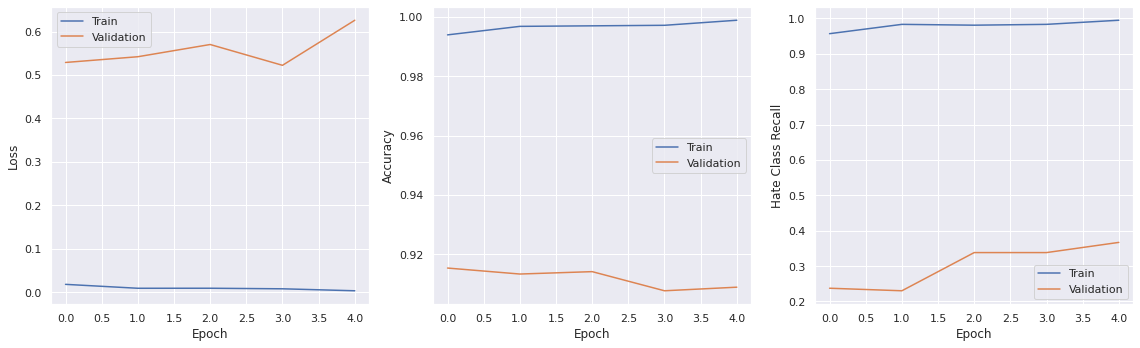

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(train_loss,label="Train")
plt.plot(eval_loss,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc,label="Train")
plt.plot(eval_acc,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,3,3)
plt.plot([x[0] for x in train_pcacc],label="Train")
plt.plot([x[0] for x in eval_pcacc],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Hate Class Recall")
plt.legend()
plt.tight_layout()



In [ ]:
pred_obj = trainer.predict(tokenized_ds["test"])

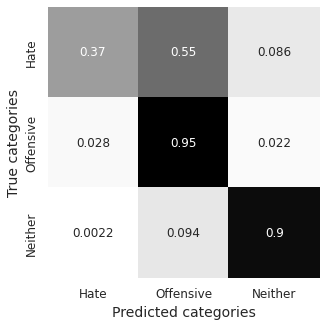

In [ ]:
preds = np.argmax(pred_obj[0],axis=1)
confusion_mat = confusion_matrix(tokenized_ds["test"]["labels"],preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_mat[i,:]/float(confusion_mat[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.set(rc={'text.usetex': False})
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True)
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#Use weighted CE loss
train_loss=[]
eval_loss=[]
train_acc=[]
eval_acc=[]
train_pcacc=[]
eval_pcacc=[]
model = AutoModelForSequenceClassification.from_pretrained(
            "roberta-base", num_labels=3)
training_args = TrainingArguments(
    output_dir="wce_model",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # remove_unused_columns=False,
)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    weighted_training = True,
)
# import warnings
# warnings.filterwarnings("ignore")
trainer.train()

wts tensor([17.2765,  1.2895,  6.0005])


Evaluation Epoch 0: 100%|██████████| 155/155 [00:09<00:00, 17.13batch/s]


	Train Loss: 0.493 | Train Acc: 83.48% | Train Per Class Acc: [0.6522075533866882, 0.8343547582626343, 0.9004573822021484]
	Eval Loss: 0.450 | Eval Acc: 76.73% | Eval Per Class Acc: [0.7122302055358887, 0.7222809195518494, 0.9775785207748413]


Evaluation Epoch 1: 100%|██████████| 155/155 [00:09<00:00, 17.00batch/s]


	Train Loss: 0.330 | Train Acc: 86.81% | Train Per Class Acc: [0.8071262240409851, 0.853723406791687, 0.9558784365653992]
	Eval Loss: 0.485 | Eval Acc: 88.23% | Eval Per Class Acc: [0.5539568662643433, 0.8870116472244263, 0.966367781162262]


Evaluation Epoch 2: 100%|██████████| 155/155 [00:09<00:00, 17.00batch/s]


	Train Loss: 0.216 | Train Acc: 90.27% | Train Per Class Acc: [0.8869093656539917, 0.8869102597236633, 0.9817057251930237]
	Eval Loss: 0.533 | Eval Acc: 86.09% | Eval Per Class Acc: [0.597122311592102, 0.8611404895782471, 0.9439462423324585]


Evaluation Epoch 3: 100%|██████████| 155/155 [00:09<00:00, 17.01batch/s]


	Train Loss: 0.121 | Train Acc: 94.25% | Train Per Class Acc: [0.9504259824752808, 0.9308510422706604, 0.9940813183784485]
	Eval Loss: 0.723 | Eval Acc: 88.67% | Eval Per Class Acc: [0.5755395889282227, 0.8949313759803772, 0.9506726861000061]


Evaluation Epoch 4: 100%|██████████| 155/155 [00:09<00:00, 17.01batch/s]

	Train Loss: 0.063 | Train Acc: 96.86% | Train Per Class Acc: [0.9814097285270691, 0.9617252349853516, 0.9962335824966431]
	Eval Loss: 0.881 | Eval Acc: 89.11% | Eval Per Class Acc: [0.5395683646202087, 0.9102429151535034, 0.921524703502655]
Time: 24.483 minutes


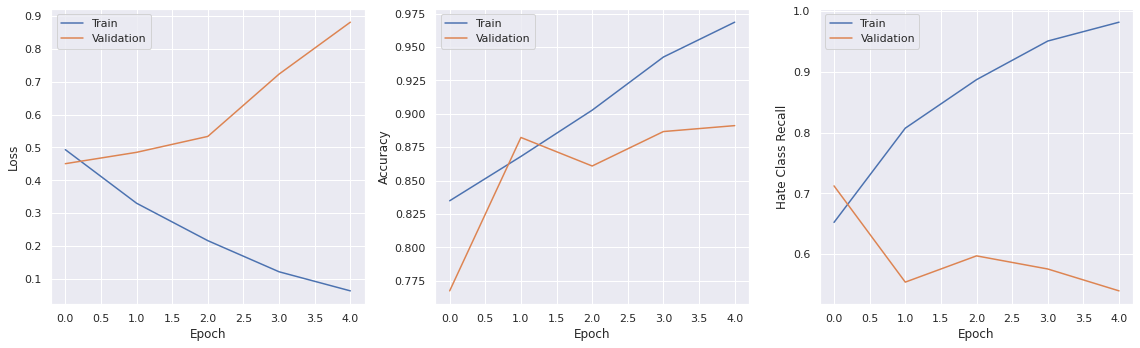

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(train_loss,label="Train")
plt.plot(eval_loss,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc,label="Train")
plt.plot(eval_acc,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,3,3)
plt.plot([x[0] for x in train_pcacc],label="Train")
plt.plot([x[0] for x in eval_pcacc],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Hate Class Recall")
plt.legend()
plt.tight_layout()

In [ ]:
pred_obj = trainer.predict(tokenized_ds["test"])

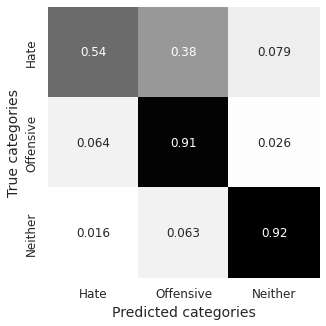

In [ ]:
preds = np.argmax(pred_obj[0],axis=1)
confusion_mat = confusion_matrix(tokenized_ds["test"]["labels"],preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_mat[i,:]/float(confusion_mat[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.set(rc={'text.usetex': False})
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True)
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
preds = np.argmax(pred_obj[0],axis=1)
preds[preds>0] = 1
preds = 1 - preds 
labs = pred_obj[1].copy()
labs[labs>0] = 1
labs = 1 - labs
f1s = f1.compute(predictions=preds, references=labs)['f1']
rec = recall.compute(predictions=preds, references=labs)['recall']
pre = precision.compute(predictions=preds, references=labs)['precision']
print(f'\tPrecision: {pre:.3f} | Recall: {rec:.3f} | F1: {f1s:.3f}')

	Precision: 0.369 | Recall: 0.540 | F1: 0.439


In [ ]:
#Smooth Labels(Use individual user labels to smoothen the overall labels to potentially get more representation for hate class)
class CustomTrainer_ls(Trainer):
    def __init__(self, weighted_training=False, **kwargs,):
          super().__init__(**kwargs)
          self.weighted_training = weighted_training
    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()
        train_loss=[]
        train_acc=[]
        eval_acc=[]

        if self.weighted_training:
            wts = sum(cls_freq)/torch.tensor(cls_freq)
            print("wts",wts)
        else:
            wts = torch.ones(3)
        criterion = torch.nn.CrossEntropyLoss(weight = wts).to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            train_pcacc_per_epoch = [0 for cls in range(3)]
            train_pccount_per_epoch = [0 for cls in range(3)]
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs["labels"]
                    labels_smooth = torch.stack((inputs['hate_speech_count'],inputs['offensive_language_count'],inputs['neither_count']),dim=-1).transpose(0,1)/inputs["count"]
                    labels_smooth = labels_smooth.transpose(0,1)
                    # print(labels)
                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(inputs['input_ids'],attention_mask = inputs['attention_mask'])
                    # get the loss
                    loss = criterion(output['logits'], labels_smooth)
                    train_loss_per_epoch += loss.item()
                    #calculate gradients
                    loss.backward()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
                    for cls in range(3):
                        train_pcacc_per_epoch[cls] += (output['logits'].argmax(1)[labels==cls] == cls).sum().item()
                        train_pccount_per_epoch[cls] += sum(labels==cls)
                    
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            train_pcacc_per_epoch = [(train_pcacc_per_epoch[cls]/train_pccount_per_epoch[cls]).item() for cls in range(3)]
            
            
            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            eval_pcacc_per_epoch = [0 for cls in range(3)]
            eval_pccount_per_epoch = [0 for cls in range(3)]
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for step, inputs in enumerate(eval_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    with torch.no_grad():
                        output = model(inputs['input_ids'],attention_mask = inputs['attention_mask'])
                        loss = criterion(output['logits'], labels)
                        eval_loss_per_epoch += loss.item()
                        eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
                        for cls in range(3):
                            eval_pcacc_per_epoch[cls] += (output['logits'].argmax(1)[labels==cls] == cls).sum().item()
                            eval_pccount_per_epoch[cls] += sum(labels==cls)
            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
            eval_pcacc_per_epoch = [(eval_pcacc_per_epoch[cls]/eval_pccount_per_epoch[cls]).item() for cls in range(3)]
        
            
            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}% | Train Per Class Acc: {train_pcacc_per_epoch}')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}% | Eval Per Class Acc: {eval_pcacc_per_epoch}')
    
        print(f'Time: {(time.time()-start)/60:.3f} minutes')

In [ ]:
##Use standard CE loss with label smoothing
model = AutoModelForSequenceClassification.from_pretrained(
            "roberta-base", num_labels=3)
# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#trainingarguments
training_args = TrainingArguments(
    output_dir="ce_model",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    remove_unused_columns=False,
)

# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#id1
trainer = CustomTrainer_ls(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
# import warnings
# warnings.filterwarnings("ignore")
trainer.train()

Evaluation Epoch 0: 100%|██████████| 155/155 [00:09<00:00, 16.87batch/s]


	Train Loss: 0.420 | Train Acc: 90.42% | Train Per Class Acc: [0.17118512094020844, 0.9667553305625916, 0.8676352500915527]
	Eval Loss: 0.279 | Eval Acc: 91.81% | Eval Per Class Acc: [0.3884892165660858, 0.9535375237464905, 0.934977650642395]


Evaluation Epoch 1: 100%|██████████| 155/155 [00:09<00:00, 16.88batch/s]


	Train Loss: 0.360 | Train Acc: 92.92% | Train Per Class Acc: [0.3477924168109894, 0.9712650179862976, 0.9351627826690674]
	Eval Loss: 0.248 | Eval Acc: 91.29% | Eval Per Class Acc: [0.08633093535900116, 0.9783527255058289, 0.8946188688278198]


Evaluation Epoch 2: 100%|██████████| 155/155 [00:09<00:00, 16.93batch/s]


	Train Loss: 0.320 | Train Acc: 94.63% | Train Per Class Acc: [0.4918667674064636, 0.9774514436721802, 0.9591068625450134]
	Eval Loss: 0.251 | Eval Acc: 91.13% | Eval Per Class Acc: [0.3884892165660858, 0.9545934796333313, 0.892376720905304]


Evaluation Epoch 3: 100%|██████████| 155/155 [00:09<00:00, 16.88batch/s]


	Train Loss: 0.274 | Train Acc: 95.92% | Train Per Class Acc: [0.6971340179443359, 0.977798342704773, 0.9634113907814026]
	Eval Loss: 0.245 | Eval Acc: 91.45% | Eval Per Class Acc: [0.30215826630592346, 0.965153157711029, 0.892376720905304]


Evaluation Epoch 4: 100%|██████████| 155/155 [00:09<00:00, 16.93batch/s]

	Train Loss: 0.230 | Train Acc: 96.89% | Train Per Class Acc: [0.8373354077339172, 0.9783765077590942, 0.9704062938690186]
	Eval Loss: 0.253 | Eval Acc: 91.01% | Eval Per Class Acc: [0.35971224308013916, 0.9572334289550781, 0.8834081292152405]
Time: 24.460 minutes


In [ ]:
#weighted CE loss with label smoothing
model = AutoModelForSequenceClassification.from_pretrained(
            "roberta-base", num_labels=3)
training_args = TrainingArguments(
    output_dir="wce_model",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    remove_unused_columns=False,
)
trainer = CustomTrainer_ls(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    weighted_training = True,
)
# import warnings
# warnings.filterwarnings("ignore")
trainer.train()

wts tensor([17.2765,  1.2895,  6.0005])


Evaluation Epoch 0: 100%|██████████| 155/155 [00:09<00:00, 16.60batch/s]


	Train Loss: 2.207 | Train Acc: 68.94% | Train Per Class Acc: [0.8613477945327759, 0.6358117461204529, 0.8789346814155579]
	Eval Loss: 0.558 | Eval Acc: 64.11% | Eval Per Class Acc: [0.8920863270759583, 0.5591341257095337, 0.9125561118125916]


Evaluation Epoch 1: 100%|██████████| 155/155 [00:09<00:00, 16.75batch/s]


	Train Loss: 1.837 | Train Acc: 73.18% | Train Per Class Acc: [0.9395816922187805, 0.6708487272262573, 0.9435028433799744]
	Eval Loss: 0.453 | Eval Acc: 73.91% | Eval Per Class Acc: [0.8057554364204407, 0.6847941279411316, 0.9506726861000061]


Evaluation Epoch 2: 100%|██████████| 155/155 [00:09<00:00, 16.54batch/s]


	Train Loss: 1.530 | Train Acc: 73.98% | Train Per Class Acc: [0.9860572814941406, 0.6747803092002869, 0.9566855430603027]
	Eval Loss: 0.463 | Eval Acc: 74.76% | Eval Per Class Acc: [0.7841726541519165, 0.6953537464141846, 0.9596412777900696]


Evaluation Epoch 3: 100%|██████████| 155/155 [00:09<00:00, 16.65batch/s]


	Train Loss: 1.187 | Train Acc: 75.96% | Train Per Class Acc: [0.9969016313552856, 0.6995258927345276, 0.9566855430603027]
	Eval Loss: 0.492 | Eval Acc: 78.71% | Eval Per Class Acc: [0.7194244861602783, 0.7523759603500366, 0.9573991298675537]


Evaluation Epoch 4: 100%|██████████| 155/155 [00:09<00:00, 16.77batch/s]


	Train Loss: 0.982 | Train Acc: 77.75% | Train Per Class Acc: [0.9976761937141418, 0.7224791646003723, 0.9572235941886902]
	Eval Loss: 0.541 | Eval Acc: 75.93% | Eval Per Class Acc: [0.7482014298439026, 0.7180570363998413, 0.9394619464874268]


Evaluation Epoch 5: 100%|██████████| 155/155 [00:10<00:00, 15.04batch/s]


	Train Loss: 0.864 | Train Acc: 78.69% | Train Per Class Acc: [0.999225378036499, 0.7349098324775696, 0.9548022747039795]
	Eval Loss: 0.557 | Eval Acc: 79.84% | Eval Per Class Acc: [0.6834532618522644, 0.7756072282791138, 0.9327354431152344]


Evaluation Epoch 6: 100%|██████████| 155/155 [00:09<00:00, 16.43batch/s]


	Train Loss: 0.807 | Train Acc: 79.11% | Train Per Class Acc: [1.0, 0.7412696480751038, 0.9502286911010742]
	Eval Loss: 0.558 | Eval Acc: 75.24% | Eval Per Class Acc: [0.7553957104682922, 0.7133051753044128, 0.9192825555801392]


Evaluation Epoch 7: 100%|██████████| 155/155 [00:09<00:00, 16.85batch/s]


	Train Loss: 0.771 | Train Acc: 79.59% | Train Per Class Acc: [1.0, 0.7475138902664185, 0.9499596953392029]
	Eval Loss: 0.657 | Eval Acc: 80.40% | Eval Per Class Acc: [0.6762589812278748, 0.7829989790916443, 0.934977650642395]


Evaluation Epoch 8: 100%|██████████| 155/155 [00:09<00:00, 16.79batch/s]


	Train Loss: 0.743 | Train Acc: 79.65% | Train Per Class Acc: [1.0, 0.7491327524185181, 0.9464622139930725]
	Eval Loss: 0.681 | Eval Acc: 82.34% | Eval Per Class Acc: [0.6834532618522644, 0.8093981146812439, 0.9282511472702026]


Evaluation Epoch 9: 100%|██████████| 155/155 [00:09<00:00, 16.66batch/s]


	Train Loss: 0.724 | Train Acc: 79.82% | Train Per Class Acc: [1.0, 0.7513875961303711, 0.9459241628646851]
	Eval Loss: 0.733 | Eval Acc: 81.61% | Eval Per Class Acc: [0.661870539188385, 0.8020063638687134, 0.9260089993476868]


Evaluation Epoch 10: 100%|██████████| 155/155 [00:09<00:00, 16.64batch/s]


	Train Loss: 0.714 | Train Acc: 79.82% | Train Per Class Acc: [1.0, 0.7508672475814819, 0.9483454823493958]
	Eval Loss: 0.677 | Eval Acc: 80.40% | Eval Per Class Acc: [0.6978417634963989, 0.7845829129219055, 0.921524703502655]


Evaluation Epoch 11: 100%|██████████| 155/155 [00:09<00:00, 16.54batch/s]


	Train Loss: 0.713 | Train Acc: 79.70% | Train Per Class Acc: [1.0, 0.75, 0.9453861117362976]
	Eval Loss: 0.694 | Eval Acc: 80.44% | Eval Per Class Acc: [0.6834532618522644, 0.7861668467521667, 0.921524703502655]


Evaluation Epoch 12: 100%|██████████| 155/155 [00:09<00:00, 16.65batch/s]


	Train Loss: 0.701 | Train Acc: 79.76% | Train Per Class Acc: [1.0, 0.7510406970977783, 0.9437718987464905]
	Eval Loss: 0.719 | Eval Acc: 79.84% | Eval Per Class Acc: [0.6834532618522644, 0.7761352062225342, 0.9304932951927185]


Evaluation Epoch 13: 100%|██████████| 155/155 [00:09<00:00, 16.69batch/s]


	Train Loss: 0.692 | Train Acc: 79.82% | Train Per Class Acc: [1.0, 0.7516188621520996, 0.9451170563697815]
	Eval Loss: 0.687 | Eval Acc: 78.91% | Eval Per Class Acc: [0.7266187071800232, 0.7645195722579956, 0.9147982597351074]


Evaluation Epoch 14: 100%|██████████| 155/155 [00:09<00:00, 16.68batch/s]

	Train Loss: 0.691 | Train Acc: 79.82% | Train Per Class Acc: [1.0, 0.7515032291412354, 0.9451170563697815]
	Eval Loss: 0.783 | Eval Acc: 81.29% | Eval Per Class Acc: [0.6690647602081299, 0.7946146130561829, 0.9372197985649109]
Time: 74.280 minutes
